In [1]:
import numpy as np
from scipy import misc
import pprint as pp
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from keras.models import Model
from keras.models import load_model
from keras.layers import Dense, Activation, Input, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import LearningRateScheduler, History
from keras.utils import np_utils
from keras.optimizers import Adam
from keras import backend as Keras
from keras.applications import InceptionV3

from sklearn import metrics

Using TensorFlow backend.


In [2]:
# import sys
# sys.path.insert(0, '/home/albert/github/DenseNet/')
# import densenet

### Mine Triplets

In [3]:
CAFFE_ROOT = '/home/albert/caffe/'
img_dir = os.listdir(CAFFE_ROOT + 'data/market-1501/bounding_box_train')

In [4]:
train_files = {}
train_arr = []
labels = []

for f in img_dir:
    if f[-4:] == '.jpg':
        idt = int(f[0:f.index('_')])
        if not any(idt == l for l in labels):
            labels.append(idt)
            train_files[idt] = []
        path = CAFFE_ROOT + 'data/market-1501/bounding_box_train/' + f
        train_files[idt].append(path)
        train_arr.append([path, idt])

labels.sort()

### Train Network

In [5]:
# Number of identities
P_param = 18
# Number of images per identity
K_param = 4

In [6]:
def output_batch_generator(train_files, labels, P=P_param, K=K_param):
    while True:
        batch = []
        idt_choice = np.random.choice(labels, P, replace=False)
        for p in range(len(idt_choice)):
            if K > len(train_files[idt_choice[p]]):
                k_choice = np.random.choice(range(len(train_files[idt_choice[p]])), K, replace=True)
            else:
                k_choice = np.random.choice(range(len(train_files[idt_choice[p]])), K, replace=False)
            for k in k_choice:
                path = train_files[idt_choice[p]][k]
                img = misc.imread(path).astype(np.float64)
                batch.append(img.tolist())
        output = np.array(batch)
        yield(output, np.zeros((P*K, 1,1, 128)))

In [7]:
def log1p(x):
    return Keras.log(1 + Keras.exp(x))

In [8]:
def dist(x1, x2):
    return Keras.sum(Keras.abs(x1 - x2))

In [9]:
def triplet_loss(y_true, y_pred, margin=0.5, P=P_param, K=K_param, output_dim = 128):
    embeddings = Keras.reshape(y_pred, (-1, output_dim))

    loss = tf.Variable(1, dtype=tf.float32)

    for i in range(P):
        for a in range(K):
            pred_anchor = embeddings[i*K + a]
            hard_pos = Keras.max(dist(pred_anchor, embeddings[i*K:(i + 1)*K]))
            hard_neg = Keras.min(dist(pred_anchor, Keras.concatenate([embeddings[0:i*K],
                                                                      embeddings[(i + 1)*K:]], 0)))
            loss += margin + hard_pos - hard_neg
    return loss

In [10]:
def evaluate_rank(net, rank, all_embeddings, all_identities, test_iter=1000):
    correct = 0
    f_choice = np.random.choice(range(len(train_arr)), np.minimum(test_iter, len(train_arr)), replace=False)
    for f in f_choice:
        query_img = misc.imread(train_arr[f][0])
        query_embedding = net.predict(query_img.reshape(1, 128, 64, 3))
        distance_vectors = np.squeeze(np.abs(all_embeddings - query_embedding))
        distance = np.sum(distance_vectors, axis=1)
        top_inds = distance.argsort()[:rank+1]
        output_classes = np.array(all_identities)[top_inds].astype(np.uint16)
        
#         pp.pprint(zip(distance[top_inds], np.array(all_identities)[top_inds].astype(np.uint16)))
        
        i = 0
        for c in output_classes:
            if c == int(train_arr[f][1]):
                i += 1
        if i > 1:
            correct += 1
#         print(correct)
    return float(correct)/test_iter

In [11]:
def pos_pair_generator(train_files=train_files, labels=labels):
    while True:
        idt = np.random.choice(labels, 1, replace=False)[0]
        sample_choice = np.random.choice(range(len(train_files[idt])), np.minimum(2, len(train_files[idt])), replace=False)
        pair = [misc.imread(train_files[idt][p]).tolist() for p in sample_choice]
        yield(np.array(pair).astype(np.uint8))

In [12]:
def neg_pair_generator(train_files=train_files, labels=labels):
    while True:
        idt_choice = np.random.choice(labels, 2, replace=False)
        pair = []
        for idt in idt_choice:
            sample = np.random.choice(range(len(train_files[idt])), 1, replace=False)[0]
            pair.append(misc.imread(train_files[idt][sample]).tolist())
        yield(np.array(pair).astype(np.uint8))

In [13]:
def l2(x1, x2):
    l2 = np.sqrt(np.sum(np.power(x1 - x2, 2)))
    return l2

In [14]:
def evaluate_dist(model, generator, n_pairs=1000):
    distances = []
    for t in range(n_pairs):
        pair = generator.next()   
        predict = [model.predict(pair[i].reshape(1,128,64,3)) for i in range(2)]
#         print predict
        dist = l2(predict[0], predict[1])
        distances.append(dist)
    return distances

According to the triplet loss paper, use an adaptive learning rate decay that is constant at first, then decays exponentially.

In [15]:
# https://medium.com/towards-data-science/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1
def step_decay(epoch):
    initial_lr = 0.0003
    drop = 0.7
    epochs_drop = 5
    lrate = initial_lr * np.power(drop,  
           np.floor((1+epoch)/epochs_drop))
    return lrate

# def step_decay(epoch):
#     init_lr = 0.0003
#     epochs_0 = 15.0
#     epochs_1 = 30.0
#     if epoch < epochs_0:
#         return init_lr
#     else:
#         return init_lr * np.power(0.001, (epoch - epochs_0)/(epochs_1 - epochs_0))

lrate = LearningRateScheduler(step_decay)
history = History()

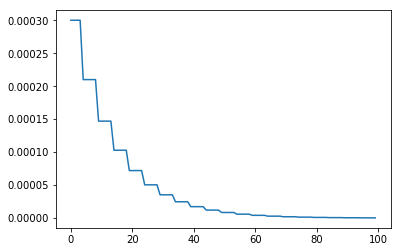

In [16]:
lr = []
for i in range(100):
    lr.append(step_decay(i))
plt.plot(np.arange(100), lr)

Replace top layer of DenseNet with a FC layer (1024) with batch normalization and ReLU and a FC layer (128). Train with all layers as learnable for 50 epochs with learning rate decay 1e-6.

In [17]:
# with tf.device('/cpu:0'):
# https://keras.io/applications/#fine-tune-inceptionv3-on-a-new-set-of-classes
i = 0
image_dim = (224, 224, 3)
base_model = InceptionV3(weights='imagenet')

base_model.summary()

96026624/96112376 [============================>.] - ETA: 0s____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, None, None, 32 864         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, None, None, 32 96          conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, None, None, 32 0           batch_normalization_1[0][0]      
_______________________________

In [20]:
new_input = Input(shape=(128,64,3), name='new_input')

base_model.outputs = [base_model.layers[-2].output]
base_model.layers[-1].outbound_nodes = []

In [21]:
print(base_model.outputs[0])

Tensor("avg_pool/Mean:0", shape=(?, 2048), dtype=float32)


In [22]:
# https://datascience.stackexchange.com/questions/21610/prepending-input-layer-to-pre-trained-model
x = base_model.outputs[0] # (new_input)
x = Dense(1024)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
predictions = Dense(128)(x)

pre_trinet = Model(inputs=base_model.input, outputs=predictions)

pre_trinet.compile(loss=triplet_loss, optimizer=Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0))

trinet = Model(inputs=new_input, outputs=pre_trinet(new_input))
trinet.compile(loss=triplet_loss, optimizer=Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0))

for layer in trinet.layers:
    layer.trainable = True

ValueError: Negative dimension size caused by subtracting 3 from 2 for 'model_1/conv2d_72/convolution' (op: 'Conv2D') with input shapes: [?,6,2,192], [3,3,192,320].

In [21]:
pre_trinet.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 112, 112, 64)  9472        input_1[0][0]                    
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 112, 112, 64)  256         conv1[0][0]                      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 112, 112, 64)  0           bn_conv1[0][0]                   
___________________________________________________________________________________________

In [19]:
# trinet = load_model('/home/albert/github/tensorflow/test_triplet_5k_margin_0.5.h5', 
#                     custom_objects={'triplet_loss':triplet_loss})

Epoch 1/25
100/100 [==============================] - 71s - loss: -7363866.8394    
Epoch 2/25
100/100 [==============================] - 66s - loss: -24207661.3100    
Epoch 3/25
100/100 [==============================] - 66s - loss: -42786104.4000    
Epoch 4/25
100/100 [==============================] - 66s - loss: -64269602.4400    
Epoch 5/25
100/100 [==============================] - 66s - loss: -88312600.8000    
Epoch 6/25
100/100 [==============================] - 66s - loss: -114836898.4800    
Epoch 7/25
100/100 [==============================] - 66s - loss: -145416074.0800    
Epoch 8/25
100/100 [==============================] - 66s - loss: -178647807.6800    
Epoch 9/25
100/100 [==============================] - 66s - loss: -213035836.3200    
Epoch 10/25
100/100 [==============================] - 66s - loss: -252103943.5200    
Epoch 11/25
100/100 [==============================] - 66s - loss: -292665199.6800    
Epoch 12/25
100/100 [==============================] - 66s

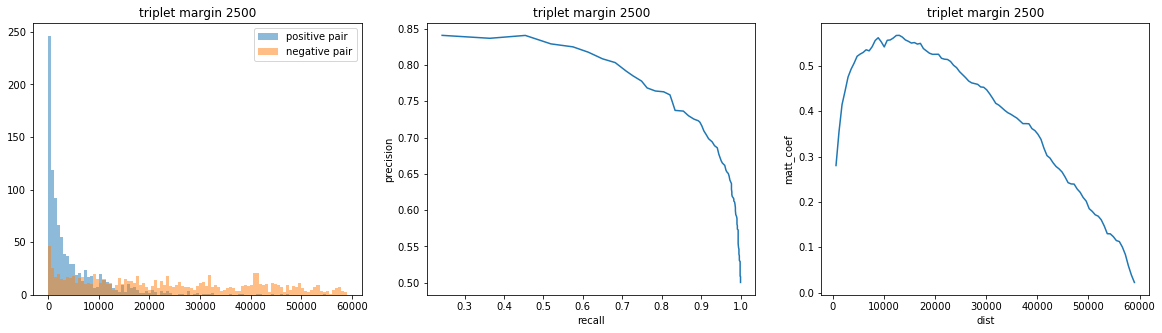

rank5 [0.061, 0.082, 0.05]
rank20 [0.187, 0.192, 0.195]
Epoch 1/25
100/100 [==============================] - 69s - loss: -1201325369.6000    
Epoch 2/25
100/100 [==============================] - 67s - loss: -1276989611.5200    
Epoch 3/25
100/100 [==============================] - 66s - loss: -1358567476.4800    
Epoch 4/25
100/100 [==============================] - 66s - loss: -1440331447.0400    
Epoch 5/25
100/100 [==============================] - 66s - loss: -1521332787.2000    
Epoch 6/25
100/100 [==============================] - 66s - loss: -1607725669.1200    
Epoch 7/25
100/100 [==============================] - 66s - loss: -1697851297.2800    
Epoch 8/25
100/100 [==============================] - 66s - loss: -1785137482.2400    
Epoch 9/25
100/100 [==============================] - 66s - loss: -1877096541.4400    
Epoch 10/25
100/100 [==============================] - 65s - loss: -1967564291.8400    
Epoch 11/25
100/100 [==============================] - 66s - loss: -20619

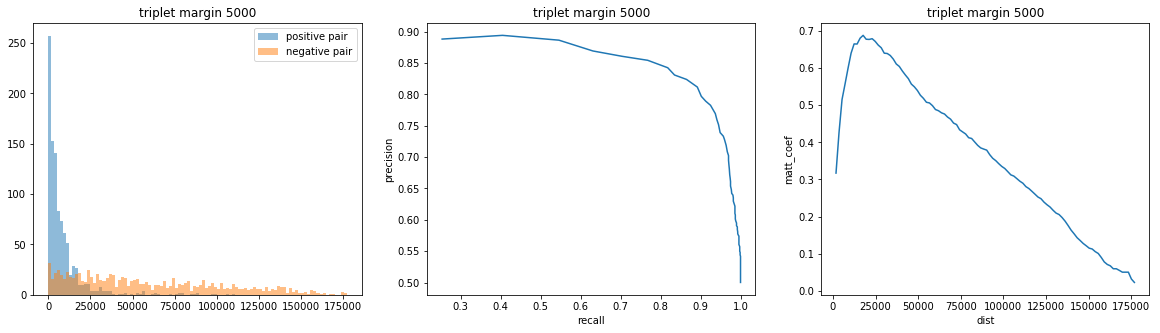

rank5 [0.073, 0.093, 0.074]
rank20 [0.249, 0.242, 0.244]
Epoch 1/25
100/100 [==============================] - 69s - loss: -3690900856.3200    
Epoch 2/25
100/100 [==============================] - 67s - loss: -3811983339.5200    
Epoch 3/25
100/100 [==============================] - 66s - loss: -3938222156.8000    
Epoch 4/25
100/100 [==============================] - 66s - loss: -4064013555.2000    
Epoch 5/25
100/100 [==============================] - 66s - loss: -4185968906.2400    
Epoch 6/25
100/100 [==============================] - 65s - loss: -4320466173.4400    
Epoch 7/25
100/100 [==============================] - 66s - loss: -4449655633.9200    
Epoch 8/25
100/100 [==============================] - 66s - loss: -4579643904.0000    
Epoch 9/25
100/100 [==============================] - 65s - loss: -4713487585.2800    
Epoch 10/25
100/100 [==============================] - 66s - loss: -4851484718.0800    
Epoch 11/25
100/100 [==============================] - 66s - loss: -4987

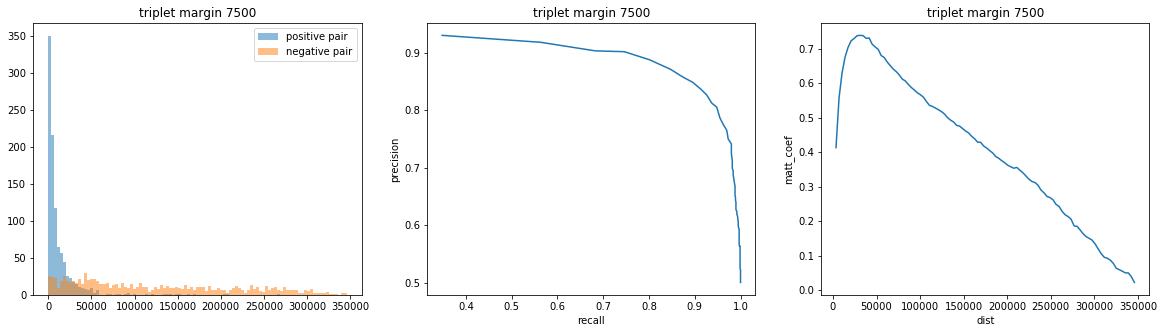

rank5 [0.111, 0.105, 0.113]
rank20 [0.31, 0.324, 0.334]
Epoch 1/25
100/100 [==============================] - 67s - loss: -7209526927.3600    
Epoch 2/25
100/100 [==============================] - 67s - loss: -7374558571.5200    
Epoch 3/25
100/100 [==============================] - 66s - loss: -7529945210.8800    
Epoch 4/25
100/100 [==============================] - 65s - loss: -7692913469.4400    
Epoch 5/25
100/100 [==============================] - 65s - loss: -7861387530.2400    
Epoch 6/25
100/100 [==============================] - 65s - loss: -8018227471.3600    
Epoch 7/25
100/100 [==============================] - 65s - loss: -8196771942.4000    
Epoch 8/25
100/100 [==============================] - 65s - loss: -8366215326.7200    
Epoch 9/25
100/100 [==============================] - 65s - loss: -8531890129.9200    
Epoch 10/25
100/100 [==============================] - 65s - loss: -8710663669.7600    
Epoch 11/25
100/100 [==============================] - 65s - loss: -88828

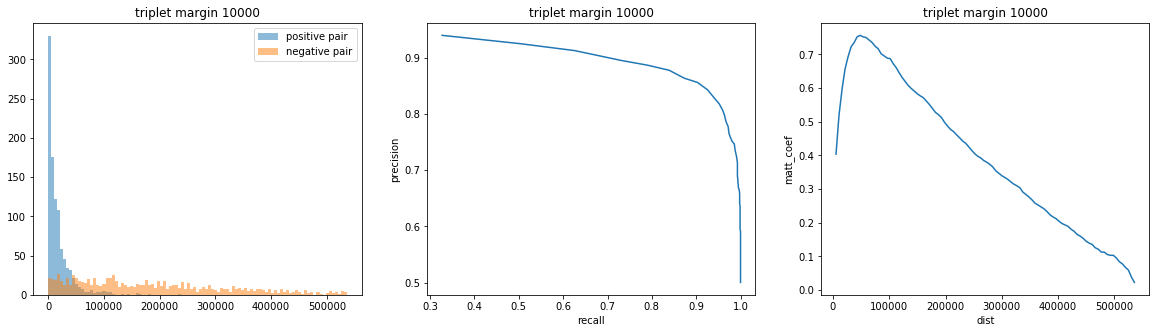

rank5 [0.107, 0.092, 0.107]
rank20 [0.361, 0.327, 0.324]
Epoch 1/25
100/100 [==============================] - 67s - loss: -11654038169.6000    
Epoch 2/25
100/100 [==============================] - 65s - loss: -11867294781.4400    
Epoch 3/25
100/100 [==============================] - 65s - loss: -12063150602.2400    
Epoch 4/25
100/100 [==============================] - 65s - loss: -12261965527.0400    
Epoch 5/25
100/100 [==============================] - 65s - loss: -12459489525.7600    
Epoch 6/25
100/100 [==============================] - 65s - loss: -12668685107.2000    
Epoch 7/25
100/100 [==============================] - 65s - loss: -12865150248.9600    
Epoch 8/25
100/100 [==============================] - 65s - loss: -13072162170.8800    
Epoch 9/25
100/100 [==============================] - 65s - loss: -13279892531.2000    
Epoch 10/25
100/100 [==============================] - 65s - loss: -13486382929.9200    
Epoch 11/25
100/100 [==============================] - 65s - l

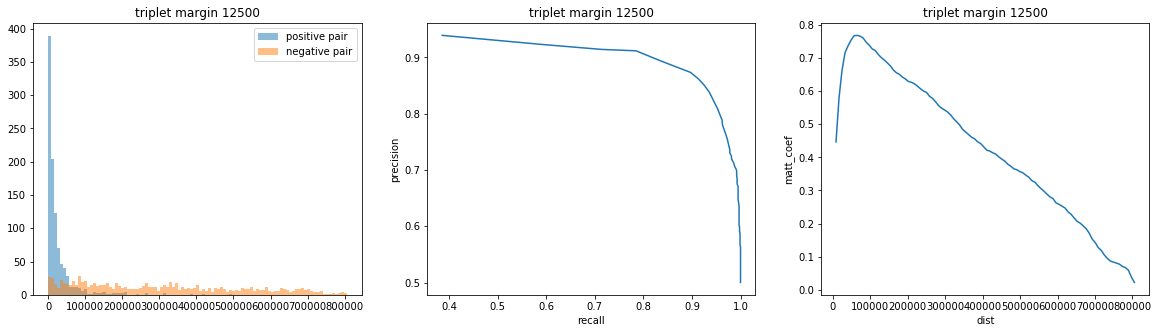

rank5 [0.121, 0.139, 0.125]
rank20 [0.39, 0.374, 0.399]
Epoch 1/25
100/100 [==============================] - 69s - loss: -16987754362.8800    
Epoch 2/25
100/100 [==============================] - 66s - loss: -17191407636.4800    
Epoch 3/25
100/100 [==============================] - 65s - loss: -17429090099.2000    
Epoch 4/25
100/100 [==============================] - 65s - loss: -17684312657.9200    
Epoch 5/25
100/100 [==============================] - 65s - loss: -17926628331.5200    
Epoch 6/25
100/100 [==============================] - 65s - loss: -18176468254.7200    
Epoch 7/25
100/100 [==============================] - 65s - loss: -18401375395.8400    
Epoch 8/25
100/100 [==============================] - 65s - loss: -18638252789.7600    
Epoch 9/25
100/100 [==============================] - 65s - loss: -18867317329.9200    
Epoch 10/25
100/100 [==============================] - 65s - loss: -19124296396.8000    
Epoch 11/25
100/100 [==============================] - 66s - lo

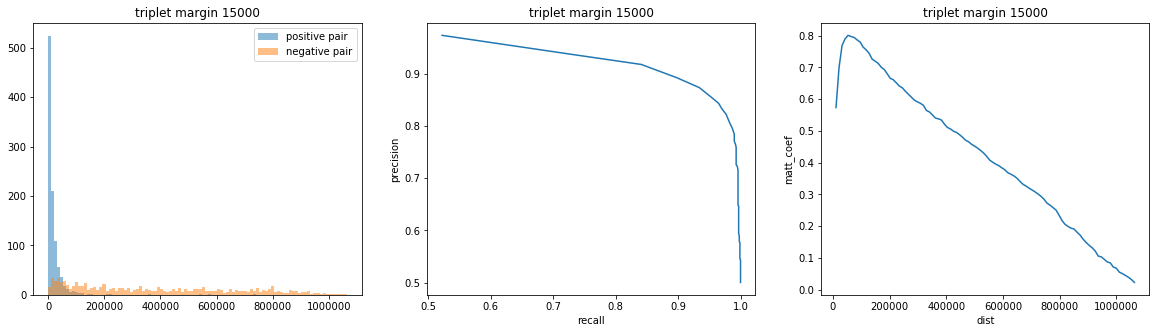

rank5 [0.165, 0.169, 0.174]
rank20 [0.478, 0.456, 0.439]
Epoch 1/25
100/100 [==============================] - 69s - loss: -23203209523.2000    
Epoch 2/25
100/100 [==============================] - 66s - loss: -23456418611.2000    
Epoch 3/25
100/100 [==============================] - 66s - loss: -23732050186.2400    
Epoch 4/25
100/100 [==============================] - 65s - loss: -24004256276.4800    
Epoch 5/25
100/100 [==============================] - 65s - loss: -24254671462.4000    
Epoch 6/25
100/100 [==============================] - 64s - loss: -24540210401.2800    
Epoch 7/25
100/100 [==============================] - 66s - loss: -24812718407.6800    
Epoch 8/25
100/100 [==============================] - 65s - loss: -25090533273.6000    
Epoch 9/25
100/100 [==============================] - 65s - loss: -25362783928.3200    
Epoch 10/25
100/100 [==============================] - 65s - loss: -25628501995.5200    
Epoch 11/25
100/100 [==============================] - 66s - l

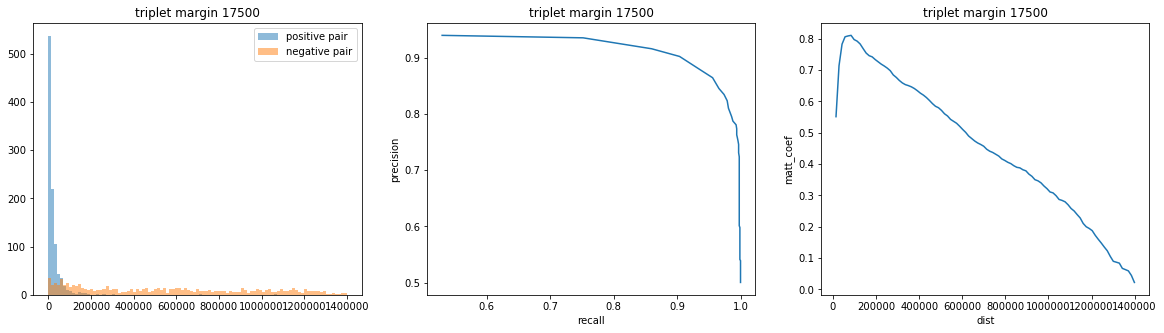

rank5 [0.183, 0.165, 0.16]
rank20 [0.456, 0.489, 0.467]
Epoch 1/25
100/100 [==============================] - 68s - loss: -30245899530.2400    
Epoch 2/25
100/100 [==============================] - 67s - loss: -30514104954.8800    
Epoch 3/25
100/100 [==============================] - 65s - loss: -30830122270.7200    
Epoch 4/25
100/100 [==============================] - 66s - loss: -31136394199.0400    
Epoch 5/25
100/100 [==============================] - 65s - loss: -31472457871.3600    
Epoch 6/25
100/100 [==============================] - 65s - loss: -31749254983.6800    
Epoch 7/25
100/100 [==============================] - 66s - loss: -32059857039.3600    
Epoch 8/25
100/100 [==============================] - 65s - loss: -32328712048.6400    
Epoch 9/25
100/100 [==============================] - 66s - loss: -32653181603.8400    
Epoch 10/25
100/100 [==============================] - 65s - loss: -32939838750.7200    
Epoch 11/25
100/100 [==============================] - 65s - lo

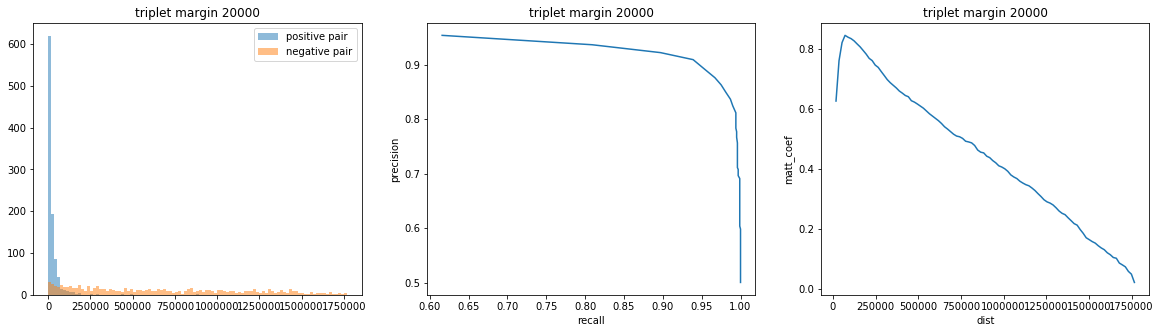

rank5 [0.207, 0.22, 0.205]
rank20 [0.533, 0.549, 0.543]
Epoch 1/25
100/100 [==============================] - 70s - loss: -38169250037.7600    
Epoch 2/25
100/100 [==============================] - 65s - loss: -38485422448.6400    
Epoch 3/25
100/100 [==============================] - 66s - loss: -38829040435.2000    
Epoch 4/25
100/100 [==============================] - 65s - loss: -39168166379.5200    
Epoch 5/25
100/100 [==============================] - 65s - loss: -39480555315.2000    
Epoch 6/25
100/100 [==============================] - 65s - loss: -39834061946.8800    
Epoch 7/25
100/100 [==============================] - 65s - loss: -40170266910.7200    
Epoch 8/25
100/100 [==============================] - 65s - loss: -40491215298.5600    
Epoch 9/25
100/100 [==============================] - 66s - loss: -40850892677.1200    
Epoch 10/25
100/100 [==============================] - 65s - loss: -41199334809.6000    
Epoch 11/25
100/100 [==============================] - 65s - lo

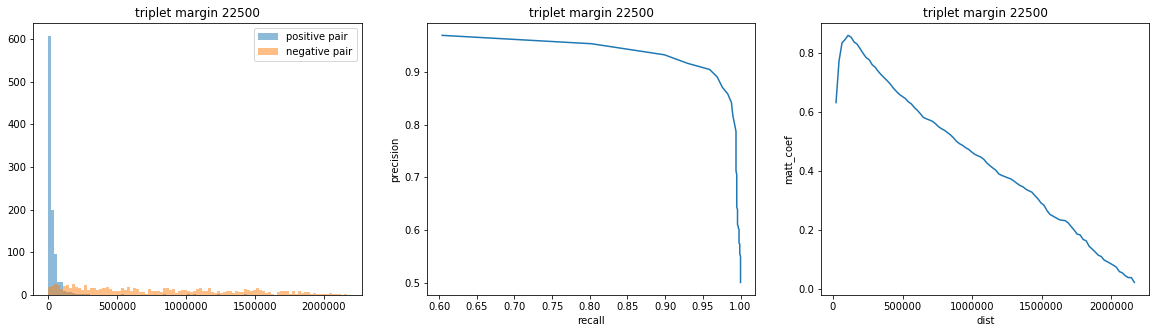

rank5 [0.21, 0.221, 0.196]
rank20 [0.541, 0.549, 0.549]
Epoch 1/25
100/100 [==============================] - 69s - loss: -46861163192.3200    
Epoch 2/25
100/100 [==============================] - 66s - loss: -47258450575.3600    
Epoch 3/25
100/100 [==============================] - 66s - loss: -47622567567.3600    
Epoch 4/25
100/100 [==============================] - 65s - loss: -48001743462.4000    
Epoch 5/25
100/100 [==============================] - 65s - loss: -48353233551.3600    
Epoch 6/25
100/100 [==============================] - 65s - loss: -48734565703.6800    
Epoch 7/25
100/100 [==============================] - 65s - loss: -49126510182.4000    
Epoch 8/25
100/100 [==============================] - 66s - loss: -49485876674.5600    
Epoch 9/25
100/100 [==============================] - 66s - loss: -49881094266.8800    
Epoch 10/25
100/100 [==============================] - 66s - loss: -50255977267.2000    
Epoch 11/25
100/100 [==============================] - 66s - lo

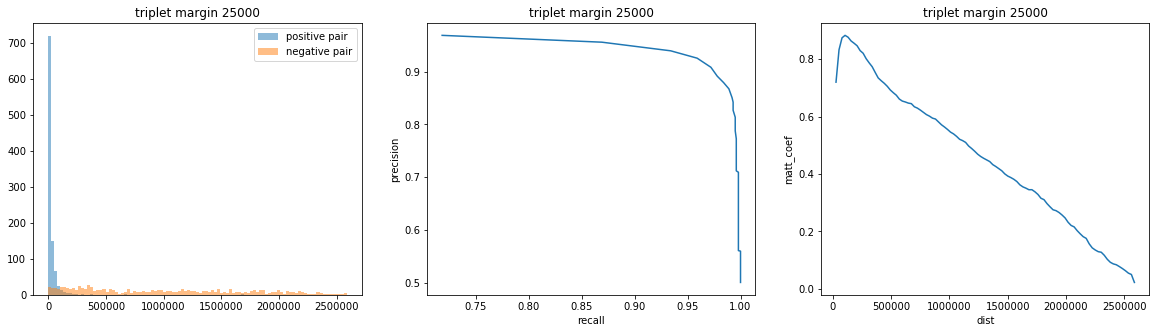

rank5 [0.227, 0.241, 0.247]
rank20 [0.572, 0.586, 0.602]
Epoch 1/25
100/100 [==============================] - 69s - loss: -56475444674.5600    
Epoch 2/25
100/100 [==============================] - 67s - loss: -56853110374.4000    
Epoch 3/25
100/100 [==============================] - 66s - loss: -57266385223.6800    
Epoch 4/25
100/100 [==============================] - 66s - loss: -57677033758.7200    
Epoch 5/25
100/100 [==============================] - 66s - loss: -58076242247.6800    
Epoch 6/25
100/100 [==============================] - 65s - loss: -58485016698.8800    
Epoch 7/25
100/100 [==============================] - 66s - loss: -58901469962.2400    
Epoch 8/25
100/100 [==============================] - 66s - loss: -59298744524.8000    
Epoch 9/25
100/100 [==============================] - 65s - loss: -59703536762.8800    
Epoch 10/25
100/100 [==============================] - 66s - loss: -60125980917.7600    
Epoch 11/25
100/100 [==============================] - 66s - l

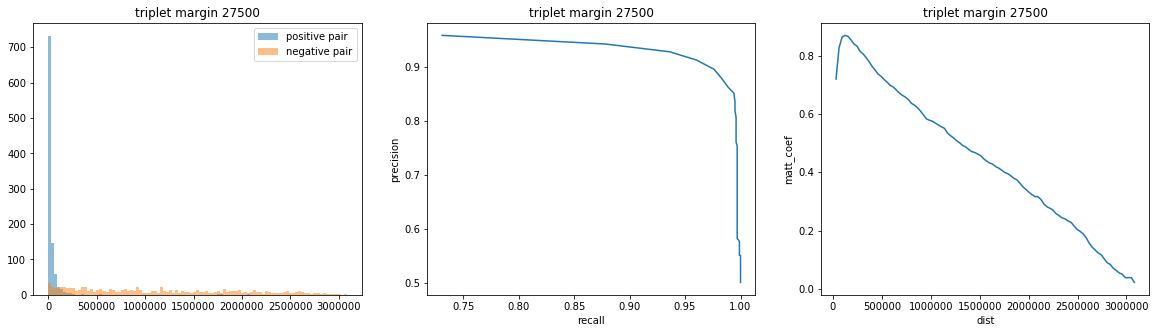

rank5 [0.242, 0.277, 0.233]
rank20 [0.623, 0.615, 0.586]
Epoch 1/25
100/100 [==============================] - 67s - loss: -66906441891.8400    
Epoch 2/25
100/100 [==============================] - 66s - loss: -67318358302.7200    
Epoch 3/25
100/100 [==============================] - 65s - loss: -67748928307.2000    
Epoch 4/25
100/100 [==============================] - 65s - loss: -68187205140.4800    
Epoch 5/25
100/100 [==============================] - 65s - loss: -68618955530.2400    
Epoch 6/25
100/100 [==============================] - 65s - loss: -69060614430.7200    
Epoch 7/25
100/100 [==============================] - 65s - loss: -69510641664.0000    
Epoch 8/25
100/100 [==============================] - 64s - loss: -69970691276.8000    
Epoch 9/25
100/100 [==============================] - 65s - loss: -70429400186.8800    
Epoch 10/25
100/100 [==============================] - 65s - loss: -70839655546.8800    
Epoch 11/25
100/100 [==============================] - 65s - l

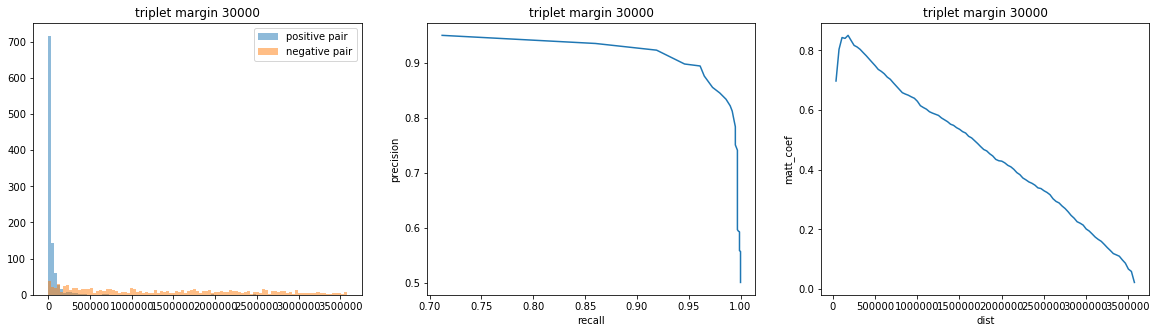

rank5 [0.235, 0.237, 0.236]
rank20 [0.599, 0.585, 0.587]


In [23]:
score = {
    'rank5' : {},
    'rank20' : {},
    'pos_distance' : {},
    'neg_distance' : {},
    'precision' : {},
    'recall' : {},
    'matt_coef' : {},
    'loss' : [],
    'file_name' : {}
}

pos_generator = pos_pair_generator()
neg_generator = neg_pair_generator()

epochs = 25
steps_per_epoch = 100

file_root = 'resnet_triplet_margin_'

for era in range(1,13):
    iterations = era * steps_per_epoch * epochs
    trinet.fit_generator(output_batch_generator(train_files, labels), 
                     steps_per_epoch=steps_per_epoch, 
                     epochs=epochs,
                        callbacks=[history])

    all_embeddings = []
    all_identities = []
    for idt in train_files.keys():
        for f in train_files[idt]:
            img = misc.imread(f)
            predict = trinet.predict(img.reshape(1, 128, 64, 3))
            all_embeddings.append(predict)
            all_identities.append(idt)

    for rank in [5,20]:
        rank_arr = []
        for x in range(3):
            rank_score = evaluate_rank(trinet, rank, all_embeddings, all_identities, test_iter=1000)
            rank_arr.append(rank_score)
        score['rank%d' % rank][iterations] = rank_arr
    
    pos_distance = evaluate_dist(trinet, pos_generator)
    score['pos_distance'][iterations] = pos_distance
    
    neg_distance = evaluate_dist(trinet, neg_generator)
    score['neg_distance'][iterations] = neg_distance
    
    score['precision'][iterations] = []
    score['recall'][iterations] = []
    score['matt_coef'][iterations] = []
    
    for thresh in np.linspace(0, np.max(np.array(pos_distance + neg_distance)), 101)[1:]:
        true = np.ones(len(pos_distance)).tolist() + np.zeros(len(neg_distance)).tolist()
        pred_pos = [int(d < thresh) for d in pos_distance]
        pred_neg = [int(d < thresh) for d in neg_distance]
        pred = pred_pos + pred_neg

        score['precision'][iterations].append(metrics.precision_score(true, pred))
        score['recall'][iterations].append(metrics.recall_score(true, pred))
        score['matt_coef'][iterations].append(metrics.matthews_corrcoef(true, pred))
    
    score['loss'] += history.history['loss']
    
    file_name = file_root + str(iterations) + '.h5'
    score['file_name'][iterations] = file_name
    trinet.save('/home/albert/github/tensorflow/models/%s' % file_name)
    
    plt.figure(figsize=(20,5))
    plt.subplot(1,3,1)
    bins = np.linspace(0, np.max(np.array(pos_distance + neg_distance)), 100)
    plt.hist(score['pos_distance'][iterations], bins, alpha=0.5, label='positive pair')
    plt.hist(score['neg_distance'][iterations], bins, alpha=0.5, label='negative pair')
    plt.legend(loc='upper right')
    plt.title('triplet margin %d' % iterations)

    plt.subplot(1,3,2)
    plt.plot(score['recall'][iterations], score['precision'][iterations])
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.title('triplet margin %d' % iterations)

    plt.subplot(1,3,3)
    plt.plot(np.linspace(0, np.max(np.array(pos_distance + neg_distance)), 101)[1:], 
             score['matt_coef'][iterations])
    plt.xlabel('dist')
    plt.ylabel('matt_coef')
    plt.title('triplet margin %d' % iterations)
    plt.show()
    
    print 'rank5', score['rank5'][iterations]
    print 'rank20', score['rank20'][iterations]

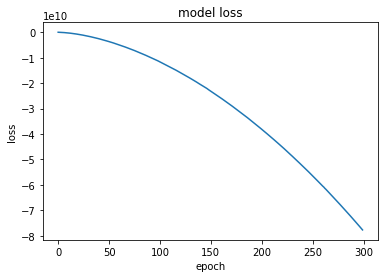

In [24]:
# summarize history for loss
plt.plot(score['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [28]:
pp.pprint(score['rank5'])

{100: [0.05, 0.075, 0.057],
 200: [0.093, 0.088, 0.082],
 300: [0.096, 0.096, 0.1],
 400: [0.097, 0.09, 0.081],
 500: [0.107, 0.124, 0.129],
 600: [0.122, 0.103, 0.117],
 700: [0.139, 0.138, 0.14],
 800: [0.135, 0.12, 0.13],
 900: [0.158, 0.181, 0.158],
 1000: [0.168, 0.159, 0.18],
 1100: [0.124, 0.135, 0.095],
 1200: [0.203, 0.186, 0.217]}


In [26]:
score_save = dict(score)

In [27]:
np.savez('/home/albert/github/tensorflow/models/resnet_triplet_margin/resnet_triplet_margin_score.npz', score_save)